<a href="https://colab.research.google.com/github/beyzoskaya/PyTorch_deepLearning/blob/main/extras/family_recognition_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

In [3]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
from google.colab import files
uploaded = files.upload()

Saving family recognition.zip to family recognition (1).zip


In [15]:
from google.colab.files import upload
import zipfile
import io

zipped_family_recognition = "family recognition.zip"
family_recognition_data_path = "extracted_data"

with zipfile.ZipFile(zipped_family_recognition, "r") as zip_ref:
    zip_ref.extractall(family_recognition_data_path)

In [28]:
general_dir = "family recognition"
binary_classification_subdir = "person or not"
binary_classification_recognition_subdir = "person or not recognition"

In [33]:
import os

train_dir_binary_classification = os.path.join(family_recognition_data_path, general_dir,binary_classification_subdir, binary_classification_recognition_subdir, "train")
test_dir_binary_classification = os.path.join(family_recognition_data_path, general_dir, binary_classification_subdir, binary_classification_recognition_subdir, "test")

In [34]:
train_dir_binary_classification, test_dir_binary_classification

('extracted_data/family recognition/person or not/person or not recognition/train',
 'extracted_data/family recognition/person or not/person or not recognition/test')

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image

person_train_dir = os.path.join(train_dir_binary_classification, "person")
not_person_train_dir = os.path.join(train_dir_binary_classification, "not person")
def display_random_images(image_dir,
                          classification_category,
                          num_images:int=3):

  image_file_names = os.listdir(image_dir)
  random.shuffle(image_file_names)

  plt.figure(figsize=(16,8))

  for i in range(num_images):
    image_name = image_file_names[i]
    image_path = os.path.join(image_dir, image_name)
    img = Image.open(image_path)
    width, height = img.size
    print(f"Image dimensions: {width} x {height}")
    plt.subplot(1, num_images, i+1)
    plt.imshow(img)
    plt.title(f"{classification_category.capitalize()} Image")
    plt.axis(False)

  plt.show()

Image dimensions: 2880 x 3840
Image dimensions: 205 x 246
Image dimensions: 1000 x 667


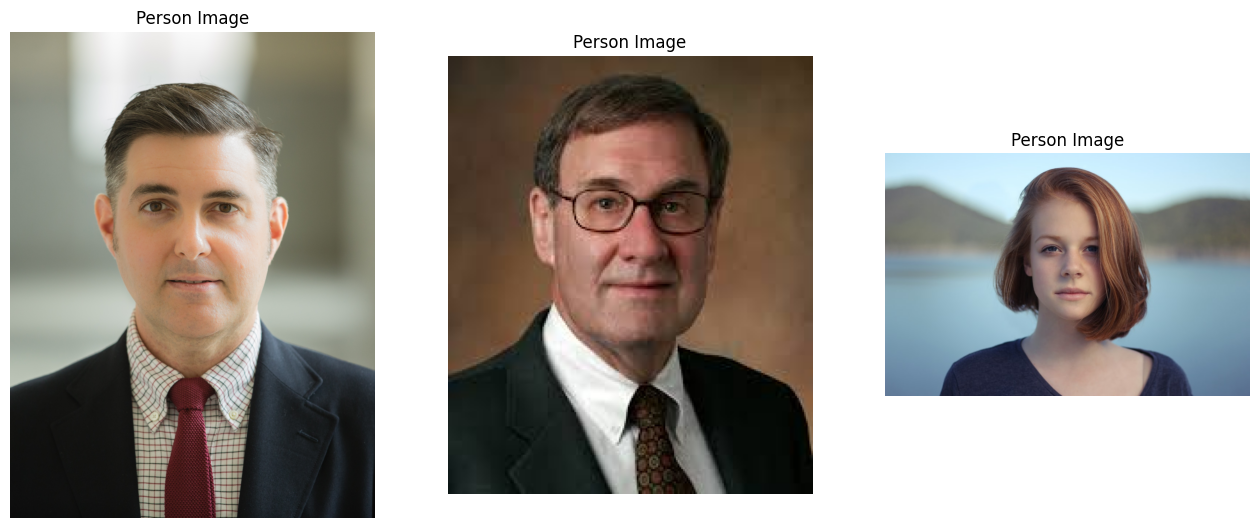

In [101]:
display_random_images(person_train_dir, "person")

Image dimensions: 1280 x 720
Image dimensions: 408 x 612
Image dimensions: 624 x 416


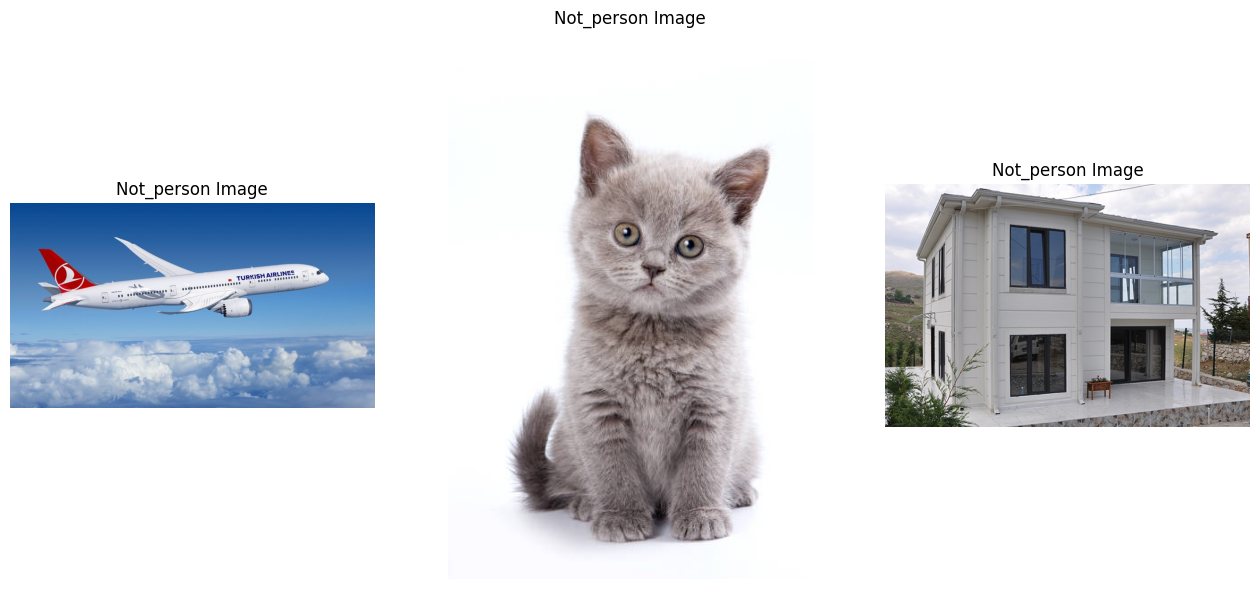

In [102]:
display_random_images(not_person_train_dir, "not_person")

In [103]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [165]:
import torchvision

def create_vit_model(num_classes:int=2,
                     seed:int=42):

  vit_b_16_weigths = torchvision.models.ViT_B_16_Weights.DEFAULT
  vit_b_16_transforms = vit_b_16_weigths.transforms()
  vit_b_16_model = torchvision.models.vit_b_16(weights=vit_b_16_weigths)

  for param in vit_b_16_model.parameters():
    param.requires_grad = False

  torch.manual_seed(42)
  vit_b_16_model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes))

  return vit_b_16_model, vit_b_16_transforms


In [166]:
vit_model, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [167]:
summary(vit_model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [172]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

#class RandomGaussianNoise(object):
#  def __init__(self,
#               mean=0,
#               std=1):
#    self.mean = mean
#    self.std = std

#  def __call__(self,image):
#    image = np.array(image) # PIL image to NumPy array for math operations
#    noise = np.random.normal(self.mean, self.std, image.shape).astype(np.uint8) # Create noise for image then retyped for get the same shape (both noise and image)
#    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8) # Add noise to the image
#    return Image.fromarray(noisy_image)


In [173]:
import torchvision.transforms as transforms

#vit_transform = transforms.Compose([
#    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
#    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust color
#    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize
#    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Randomly erase parts of the image,
#    vit_transforms
#])

vit_transform = transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms
])


In [174]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create dataset objects for the train and test sets
train_dataset = ImageFolder(train_dir_binary_classification, transform=vit_transform)
test_dataset = ImageFolder(test_dir_binary_classification, transform=vit_transform)

# Create data loaders for the train and test sets
batch_size = 1  # Adjust as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [185]:
len(train_dataloader), len(test_dataloader)

(38, 20)

In [64]:
#from torchvision import datasets, transforms
#train_data = datasets.ImageFolder(train_dir_binary_classification, transform=vit_transform)

In [175]:
class_names = train_dataset.classes
class_names

['not person', 'person']

In [176]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=0.01)

In [179]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device) -> Tuple[float, float]:

  model.train()
  train_loss, train_acc = 0,0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss=loss_fn(y_pred, y)
    train_loss = train_loss + loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
    train_acc = train_acc + (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test(model:torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device) -> Tuple[float, float]:
  model.eval()
  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logit = model(X)
      loss = loss_fn(test_pred_logit, y)
      test_loss = test_loss + loss.item()

      test_pred_labels = test_pred_logit.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

from numpy.random import test
def train_results(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  test_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module,
                  epochs:int,
                  device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
            }

  model.to(device)

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
      test_loss, test_acc = test(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)

      # Print out what's happening
      print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [180]:
vit_b_16_results = train_results(vit_model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: ignored

In [181]:
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3905, done.
remote: Counting objects: 100% (1096/1096), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 3905 (delta 986), reused 985 (delta 936), pack-reused 2809
Receiving objects: 100% (3905/3905), 649.58 MiB | 41.12 MiB/s, done.
Resolving deltas: 100% (2277/2277), done.
Updating files: 100% (248/248), done.


In [183]:
from going_modular.going_modular import engine
vit_b_16_results = engine.train (vit_model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0028 | train_acc: 1.0000 | test_loss: 0.0477 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0420 | train_acc: 0.9737 | test_loss: 0.4710 | test_acc: 0.9000
Epoch: 3 | train_loss: 0.0012 | train_acc: 1.0000 | test_loss: 0.4097 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.0382 | train_acc: 0.9737 | test_loss: 0.0019 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.6875 | test_acc: 0.9500


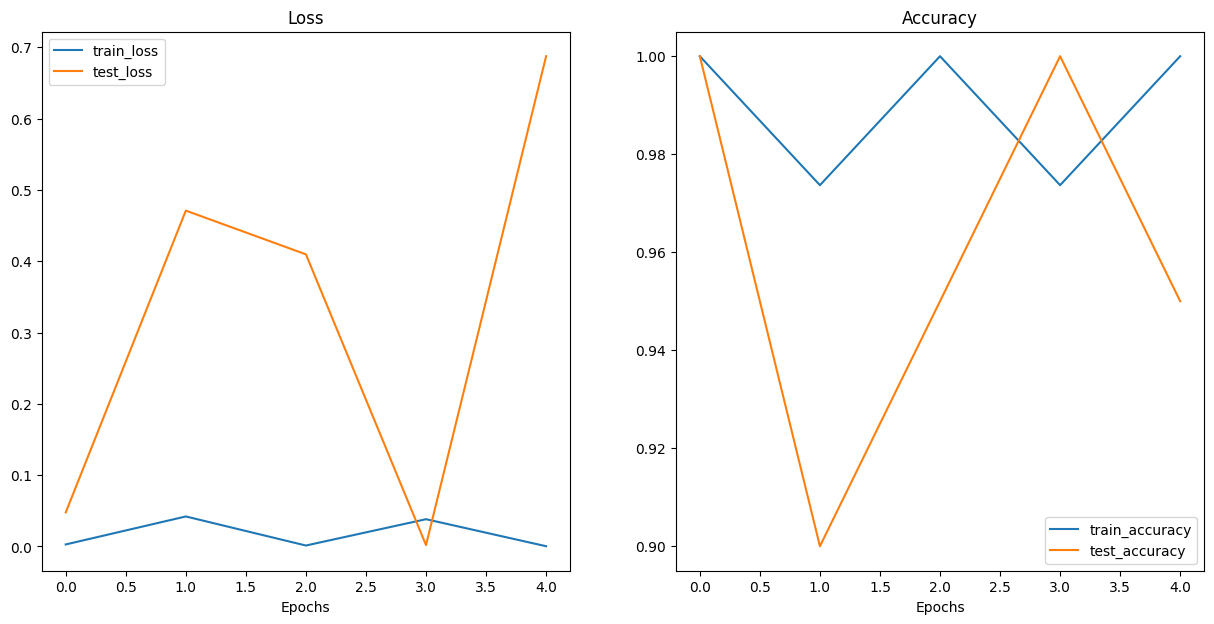

In [184]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_b_16_results)